Benjamin Fuller

An exploratory data analysis of an Alaskan salmon dataset.
taken from: https://knb.ecoinformatics.org/view/doi:10.5063/F1707ZTM

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The salmon dataset 'ASL_master' is a large file (3.58 GB). Great for analysis, but slow on read. Allow some time for the next line to initially run its code. Once on a pandas dataframe, the data can be read and manipulated much faster and more efficiently.

In [6]:
file_path = 'ASL_master.csv'
df = pd.read_csv(file_path, delimiter=',', low_memory=False)
print(df)

          Species Length.Measurement.Type  sampleYear    ASLProjectType  \
0         chinook        length not taken      1992.0  commercial catch   
1         chinook        length not taken      1992.0  commercial catch   
2         chinook        length not taken      1992.0  commercial catch   
3         chinook        length not taken      1992.0  commercial catch   
4         chinook        length not taken      1992.0  commercial catch   
...           ...                     ...         ...               ...   
14347456  sockeye                     NaN      2015.0      test fishing   
14347457  sockeye                     NaN      2015.0      test fishing   
14347458  sockeye                     NaN      2015.0      test fishing   
14347459  sockeye                     NaN      2015.0      test fishing   
14347460  sockeye                     NaN      2015.0      test fishing   

                                    LocationID  sampleDate  Length  Weight  \
0         Affleck Can

In [7]:
df.columns

Index(['Species', 'Length.Measurement.Type', 'sampleYear', 'ASLProjectType',
       'LocationID', 'sampleDate', 'Length', 'Weight', 'Sex', 'Salt.Water.Age',
       'DataSource', 'cardNo', 'fishNum', 'Age.Error', 'Fresh.Water.Age',
       'Sex.Determination.Method', 'subSystem', 'Flag', 'Gear', 'SASAP.Region',
       'LocationUnique', 'DistrictID', 'Sub.DistrictID', 'Stat.area', 'Lat',
       'Lon', 'AWC_CODE'],
      dtype='object')

In [8]:
df.Species.unique()

array(['chinook', 'chum', 'coho', 'pink', 'sockeye'], dtype=object)

Let's gather all the chinook salmon with recorded lengths and sample dates.

In [10]:
ch_df = df.groupby('Species')
ch_df = ch_df.get_group('sockeye').dropna(subset=['sampleDate', 'Length'])
ch_df['sampleYear'] = ch_df['sampleYear'].astype(int)
#sorted_ch_df = ch_df.sort_values(by='sampleDate')

In [11]:
ch_df.sampleYear.dtype

dtype('int64')

Given the large dataset, it's best to remove outliers as it can be faulty data and/or skew our analysis later.
For data with a normal distribution like this one, it's best to use a Z-score method to weed out any outliers.

In [13]:
from scipy.stats import zscore

ch_df['zscore'] = zscore(ch_df['Length'])

# consolidate back into our chinook dataframe
# any data points over 3 standard deviations are removed
ch_df = ch_df[(ch_df['zscore'] >= -3) & (ch_df['zscore'] <= 3)]

Using a line or scatterplot with this much data is not ideal. Overplotting points will mean that individual points will not be seen as they overlap one another. This also decreases the visual clarity of the plot and makes it difficult to interpret the graph data. A hexbin can solve this problem for large amounts of data points by "binning" similarlyrelated data into one hexagonal space of the grid. By applying a sequential colormap to the hexbin, we can interpret the large dataset more accurately. Oh, and it looks cool.

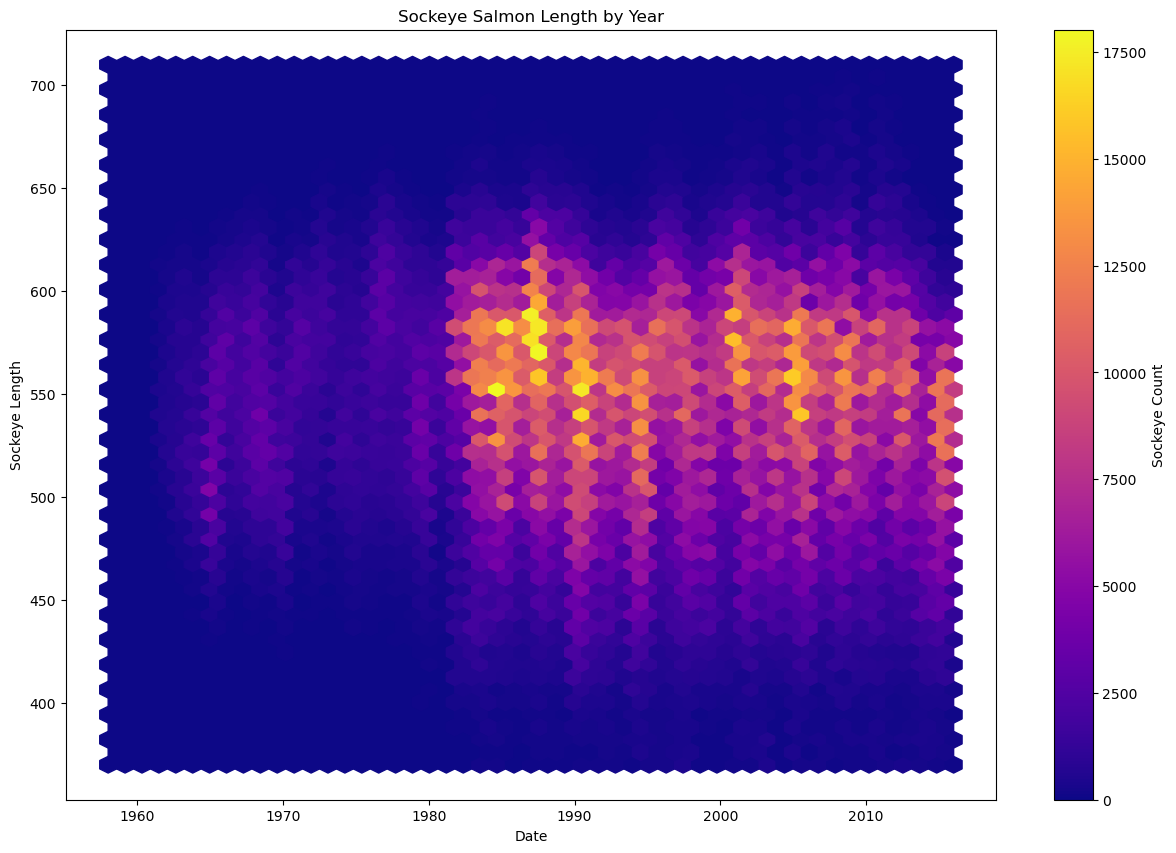

In [15]:
x = ch_df['sampleYear']
y = ch_df['Length']
# Plot the chinook fish
plt.figure(figsize=(15, 10))
plt.hexbin(x, y, gridsize=50, cmap='plasma')
plt.colorbar(label='Sockeye Count')

# Add labels, title
plt.xlabel('Date')
plt.ylabel('Sockeye Length (mm)')
plt.title('Sockeye Salmon Length (mm) by Year')

# Show the plot
plt.show()

This hexbin map gives us a good idea of the density of the data by sockeye salmon length. However, since 1982, there has been more data collection which makes years 1981 and earlier not as pronounced. Perhaps the data we want is the average sockeye salmon length per year.

Let's get the average length of the sockeye per year, outliers removed, no visualization.

In [268]:
avg_length_per_year = ch_df.groupby('sampleYear')['Length'].mean()
count_per_year = ch_df.groupby('sampleYear').size()
combined_df = pd.DataFrame({
    'Average Length': avg_length_per_year,
    'Count': count_per_year
})

print(combined_df)

            Average Length   Count
sampleYear                        
1958            559.822414     580
1959            533.489437     284
1960            598.915000     400
1961            529.000000       2
1962            551.991135    7783
1963            543.129842   17298
1964            531.353903   24696
1965            522.465655   50269
1966            554.263754   32936
1967            551.219007   37008
1968            548.250583   47170
1969            539.897315   36013
1970            525.976802   38537
1971            558.764597   36189
1972            550.076032   25213
1973            576.561187   21230
1974            548.635355   29009
1975            543.040662   29290
1976            557.590339   28299
1977            574.252084   41379
1978            558.736837   41518
1979            547.164571   43422
1980            536.202041   44877
1981            554.858199   42743
1982            556.918425  116751
1983            548.142793  150295
1984            548.

In [270]:
# remove the first 5 rows for low count in place, starting in the year 1963
combined_df = combined_df.drop(combined_df.index[[0, 1, 2, 3, 4]])

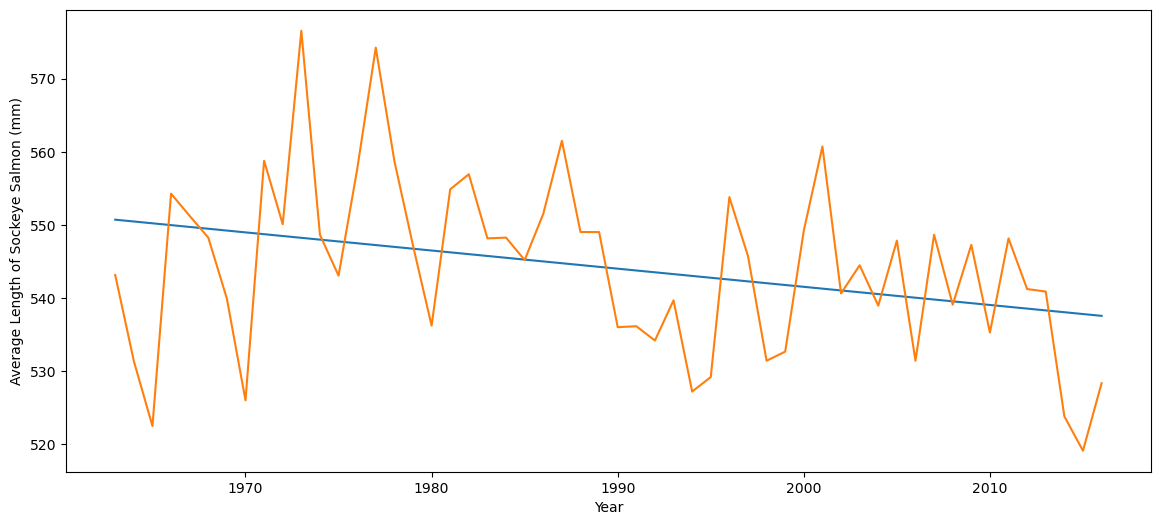

In [272]:
z = np.polyfit(combined_df.index, combined_df['Average Length'], 1)
p = np.poly1d(z)
year = combined_df.index

plt.figure(figsize=(14, 6))
plt.plot(year, p(year))
plt.plot(combined_df.index, combined_df['Average Length'])
plt.xlabel('Year')
plt.ylabel('Average Length of Sockeye Salmon (mm)')

plt.show()

In [274]:
# polyfit outputs 2 values: slope and intercept
# the first value is our slope, or how much average sockeye salmon length changes per year
print("The rate at which sockeye salmon length changes per year is " + str(z[0]))
ten_year_decline = z[0] * 10
ten_year_decline

The rate at which sockeye salmon length changes per year is -0.24833704087851383


-2.483370408785138

The data, when fitting a 1st degree polynomial regression to Sockeye Salmon lengths by year starting in 1963, suggests that the average lengths of Sockeye Salmons are dropping by around 2.5 millimeters every 10 years.